# Homework 5 Q1
#### Michael Kupperman
Eigenvectors, power iterations, and randomized linear algebra

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 300

In [3]:
# Optional - set width to 100% of screen (- buffer). Good for laptops, bad for ultrawides
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 1. Eigenvalues and Power Iteration
### a) 
Generate a random, symmetric matrix `A` which is ` m x m ` where $ m = 10 $.  Use the `EIGS` command in MATLAB (or the equivalent `np.linalg.eigen` in Python) to give you the ground truth eigenvalues and eigenvectors.

In [4]:
m = 10

In [5]:
# Introduce a random state generator
rng = np.random.default_rng()
A = rng.standard_normal(m * m).reshape(m,m)
for i in range(m):
    for j in range(i):
        A[i,j] = A[j,i]

true_eigenvalues, true_eigenvectors = np.linalg.eig(A)

print('True Eigenvalues are:')
print(*true_eigenvalues)

print('Associated Eigenvectors are:')
print(true_eigenvectors)

True Eigenvalues are:
-4.73689841120034 4.354233737452332 -3.46450262187843 -2.9302454734203787 -1.8823896506188922 3.0013878715733364 -0.2847720013748086 1.0506365662288204 1.3771467440673422 1.7266618549974555
Associated Eigenvectors are:
[[-0.241686   -0.33693205  0.29361603  0.31935538 -0.48937666  0.14422075
   0.15570734  0.27099268 -0.53087014  0.00850803]
 [-0.4865936  -0.22475037  0.1028817   0.14764108  0.18144826  0.07384822
  -0.72993711 -0.32883466 -0.0188558   0.02565974]
 [ 0.09528441  0.38363733 -0.17847406 -0.18337449 -0.0504273   0.25508568
  -0.06302633 -0.29642149 -0.54074885  0.57131877]
 [-0.48257467  0.30038791  0.14564368 -0.10216409  0.07201616  0.57910773
   0.14605489  0.34720844  0.36201492  0.17817574]
 [ 0.07085908 -0.05687775  0.48898195 -0.49833159 -0.2602612  -0.3771098
  -0.25307007  0.21881952  0.15582373  0.39768206]
 [ 0.29563579  0.02016148 -0.30585352  0.55023934 -0.28820392  0.03972598
  -0.31336859  0.2569213   0.33644937  0.39222063]
 [-0.52676

### b) 
Find the largest eigenvalue with the power iteration method.  Compare the accuracy of the method as a function of iterations.

In [73]:
def power_iter(mat, nsteps, init_guess=None):
    """ Perform `nsteps` of power iteration on init_guess using matrix `mat`. 
        If no guess is provided \hat{e}_1 is used instead """
    if init_guess is None:
        init_guess = np.zeros(mat.shape[0])
        init_guess[0] = 1
    iterates = [init_guess]
    eigens = []
    for idx in range(nsteps):
        v1 = np.dot(mat, iterates[-1]) 
        v1 = v1 / np.linalg.norm(v1)
        iterates.append(v1)
        eigens.append(np.vdot(v1, np.dot(mat, v1)))
    return iterates, eigens

In [7]:
n_iter = 500
iterates, eigens = power_iter(A, n_iter)
estimate_eigenvalue = eigens[-1]
errors = abs(eigens - true_eigenvalues[0])

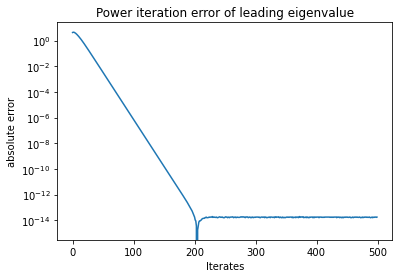

In [9]:
plt.plot(np.arange(n_iter), errors)
plt.yscale('log')
plt.xlabel('Iterates')
plt.ylabel('absolute error')
plt.title('Power iteration error of leading eigenvalue')
plt.savefig('Figures/f1.eps')
plt.show()

In [10]:
errors[350]

1.687538997430238e-14

We are able to obtain the eigenvalue within 50 to 350 iterates depending on the matrix to an error on the order (or slightly better) of machine epsilon, $2 \times 10^{-16}$.


The first few initial iterates are not indicative of the convergence rate given the quality of the initial guess. The eigenvalue conveges at a decent speed until we approach machine epsilon. For some matricies, the iteration gives the exact eigenvalue up to machine precision from the `np.linalg.eigen` command.




### C)

Find all ten eigenvalues by Rayleigh Quotient iteration and guessing initial ”eigenvectors”. Compare the accuracy of the method as a function of iterations and discuss your initial guesses to find all eigenvalue/eigenvector pairs.

In [20]:
def RQiter(A, steps, init_guess):
    """Iterate for `steps` using Rayleigh Quotient Iteration"""
    guesses = [init_guess / np.linalg.norm(init_guess)]
    eigenvalues = [np.vdot(guesses[0], np.dot(A, guesses[0]))]

    for k in range(steps):
        Am = A - eigenvalues[-1] * np.eye(A.shape[0], A.shape[1]) 
        w = np.linalg.solve(Am, guesses[-1])
        v = w/np.linalg.norm(w)
        guesses.append(v)
        eigenvalues.append(np.vdot(v, np.dot(A, v)))
    return guesses, eigenvalues

In [21]:
init_guess = np.zeros(A.shape[0])
init_guess[1] = 1
nsteps = 7
eigenvec_iter, eigenval_iter = RQiter(A, nsteps, init_guess)

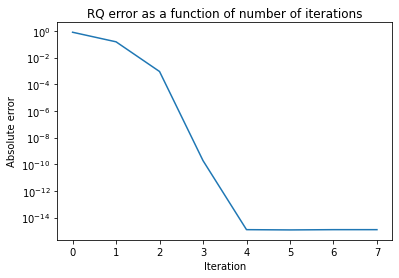

In [22]:
np_eigenval_iter = np.asarray(eigenval_iter)
loc = np.argmin(np.abs(np_eigenval_iter[-1] - true_eigenvalues))
plt.plot(np.arange(nsteps+1), np.abs(np_eigenval_iter - true_eigenvalues[loc]))
plt.yscale('log')
plt.title('RQ error as a function of number of iterations')
plt.ylabel('Absolute error')
plt.xlabel('Iteration')
plt.savefig('Figures/f2.eps')
plt.show()

The initial guess $\hat{e}_2$ gives a good estimate of the eigenvalue after three iteration of the Rayleigh Quotient method. We reach machine epsilon after four iterations, and are unable to attain or bypass machine epsilon.

Our strategy is to guess an initial vector and use it to compute an eigenvalue. We'll sample until we find all eigenvalues. 

In [15]:
eigenvalues_found = np.full(m, fill_value=np.inf)
n_eigenvalues_found = 0
eigenvectors_found = []
ntests = 0
while n_eigenvalues_found < m:
    ntests += 1
    # Loop until we find all eigenvalues
    eigen_guess = rng.standard_normal(m)  # get a random guess
    # Map the random guess into the orthogonal subspace
    # We'll do a quick orthogonal triangularization to get to about the right direction, the algorithm is good enough to pickup the slack
    for index in range(n_eigenvalues_found):
        eigen_guess -= np.dot(eigen_guess, eigenvectors_found[index]) / np.linalg.norm(eigenvectors_found[index]) * eigenvectors_found[index] 
    eigen_guess = eigen_guess / np.linalg.norm(eigen_guess)
    evec_iter, eval_iter = RQiter(A, 8, eigen_guess)  # iterate to the eigenvalue
    #See if we already found that eigenvalue
    eigen_errors = np.abs(eigenvalues_found - eval_iter[-1])
    if ntests == 1:
        # The first eigenvalue must be added
        eigenvalues_found[n_eigenvalues_found] = eval_iter[-1]
        n_eigenvalues_found += 1
        eigenvectors_found.append(evec_iter[-1])
    elif np.amin(eigen_errors) > (10 ** -10):
        # eigenvalue must be different enough
        eigenvalues_found[n_eigenvalues_found] = eval_iter[-1]
        n_eigenvalues_found += 1
        eigenvectors_found.append(evec_iter[-1])
print(ntests)

10


In [16]:
print(*eigenvalues_found)

1.050636566228821 4.354233737452329 -2.930245473420375 -1.8823896506188937 -0.28477200137480735 1.37714674406734 -4.736898411200357 1.7266618549974555 3.0013878715733338 -3.464502621878432


In [17]:
# Sort the eigenvalues so we align pairs and find errors
RQ_errors = np.sort(eigenvalues_found) - np.sort(true_eigenvalues)
print(RQ_errors)

[-1.77635684e-14 -1.77635684e-15  3.55271368e-15 -1.55431223e-15
  1.27675648e-15  6.66133815e-16 -2.22044605e-15  0.00000000e+00
 -2.66453526e-15 -2.66453526e-15]


### d)
Repeat parts b/c with a random matrix that is not symmetric. Be sure to plot the eigenvalues in the complex plane. 

In [37]:
# First make the m by m matrix
D = rng.standard_normal(m * m).reshape(m,m)

true_eigenvalues_D, true_eigenvectors_D = np.linalg.eig(D)

print('True Eigenvalues are:')
print(*true_eigenvalues_D)

print('Associated Eigenvectors are:')
print(true_eigenvectors_D)

True Eigenvalues are:
(3.1222333192954963+0j) (1.8622582607019196+1.3377629295077964j) (1.8622582607019196-1.3377629295077964j) (-0.5673071480146334+2.141246890088279j) (-0.5673071480146334-2.141246890088279j) (-1.271913749702506+1.8180459589729812j) (-1.271913749702506-1.8180459589729812j) (-1.883079337874104+0j) (0.30096079936601183+0j) (0.016678250118384755+0j)
Associated Eigenvectors are:
[[ 0.07753608+0.j          0.36199162-0.25781136j  0.36199162+0.25781136j
  -0.36654919-0.10893239j -0.36654919+0.10893239j -0.02491515+0.00515682j
  -0.02491515-0.00515682j -0.64218347+0.j         -0.20213393+0.j
   0.19726466+0.j        ]
 [ 0.21049907+0.j          0.05856065+0.38020336j  0.05856065-0.38020336j
  -0.19072779+0.354762j   -0.19072779-0.354762j   -0.1982743 -0.3681363j
  -0.1982743 +0.3681363j   0.1975906 +0.j          0.47104062+0.j
  -0.27308916+0.j        ]
 [ 0.48618462+0.j          0.45309001+0.j          0.45309001-0.j
  -0.06884985+0.03822728j -0.06884985-0.03822728j -0.1904

Let's plot the true eigenvalues.

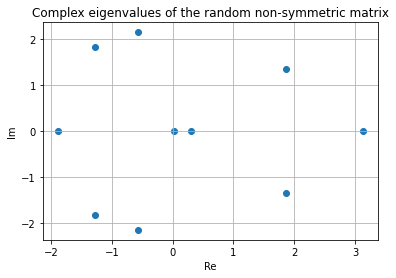

In [38]:
# Take apart the complex numbers into Re-Im components
Re_exact = [v.real for v in true_eigenvalues_D]
Im_exact = [v.imag for v in true_eigenvalues_D]
plt.scatter(Re_exact, Im_exact)
plt.grid(True)
plt.xlabel('Re')
plt.ylabel('Im')
plt.title('Complex eigenvalues of the random non-symmetric matrix')
plt.savefig('Figures/f3.eps')
plt.show()

Let's do power iteration!

In [107]:
n_iter = 200
init_guess = np.zeros(10, np.complex)
init_guess[2] = 1 + 1j
iterates_D, eigens_D = power_iter(D, n_iter, init_guess=init_guess)
estimate_eigenvalue_D = eigens_D[-1]
errors_D = abs(eigens_D - true_eigenvalues_D[0])

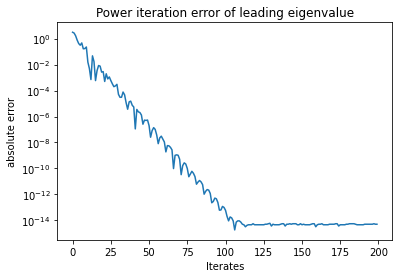

In [108]:
plt.plot(np.arange(n_iter), errors_D)
plt.yscale('log')
plt.xlabel('Iterates')
plt.ylabel('absolute error')
plt.title('Power iteration error of leading eigenvalue')
plt.savefig('Figures/f4.eps')

In [44]:
errors_D[-1]

4.440892098500626e-15

Yikes! We're not able to get a particularily stable convergence/sequence of iterates, but our final error is respectable, albeit it took many more iterations to get to the same tolerance (we're still talking about hundreds of iterations).

Let's check if Rayleigh Quotient iteration will give us a better result for the non-symetric matrix.

In [49]:
init_guess = np.zeros(D.shape[0])
init_guess[1] = 1
nsteps = 10
eigenvec_iter_D, eigenval_iter_D = RQiter(D, nsteps, init_guess)

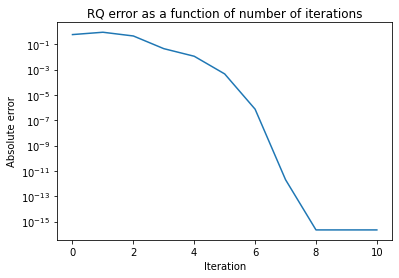

In [50]:
np_eigenval_iter_D = np.asarray(eigenval_iter_D)
loc = np.argmin(np.abs(np_eigenval_iter_D[-1] - true_eigenvalues_D))
plt.plot(np.arange(nsteps+1), np.abs(np_eigenval_iter_D - true_eigenvalues_D[loc]))
plt.yscale('log')
plt.title('RQ error as a function of number of iterations')
plt.ylabel('Absolute error')
plt.xlabel('Iteration')
plt.savefig('Figures/f5.eps')
plt.show()


That seems to be working about as good (it's much better than power iteration), but it's not nearly as good as the symmetric matrix. Note that the first few iterations are not significantly useful for this iteration, whereas we see immediate steps towards the eigenvalue in the symmetric case.

In [103]:
eigenvalues_found = np.full(m, fill_value=np.inf, dtype=np.cdouble)
n_eigenvalues_found = 0
eigenvectors_found = []
ntests = 0
while n_eigenvalues_found < m:
    ntests += 1
    # Loop until we find all eigenvalues
    ej_1 = np.zeros(m)
    ej_1[1] = 1
    ej_1 = 1j * ej_1
    eigen_guess = rng.standard_normal(m) + ej_1 # get a random guess and a complex component
    eigen_guess = eigen_guess / np.linalg.norm(eigen_guess)
    evec_iter, eval_iter = RQiter(D, 12, eigen_guess)  # iterate to the eigenvalue
    # Check that we converged 
    #if abs(eval_iter[-2] - eval_iter[-1]) > 10 ** (-14):
    #    continue
    
    #See if we already found that eigenvalue
    eigen_errors = np.abs(eigenvalues_found - eval_iter[-1])
    if ntests == 1:
        # The first eigenvalue must be added
        eigenvalues_found[n_eigenvalues_found] = eval_iter[-1]
        n_eigenvalues_found += 1
        eigenvectors_found.append(evec_iter[-1])
    elif np.amin(eigen_errors) > (10 ** -10):
        # eigenvalue must be different enough
        eigenvalues_found[n_eigenvalues_found] = eval_iter[-1]
        n_eigenvalues_found += 1
        eigenvectors_found.append(evec_iter[-1])
    if ntests > 2000:  # ensure we stop eventually
        break
print(ntests)

283


We are definately finding repeated eigenvalues (as ntests >> 10)

Let's sort the values we got to see that we don't have any repeats and we found about the right quantities

In [104]:
np.sort(eigenvalues_found)

array([-1.88307934+2.77555756e-17j, -1.27191375-1.81804596e+00j,
       -1.27191375+1.81804596e+00j, -0.56730715-2.14124689e+00j,
       -0.56730715+2.14124689e+00j,  0.01667825+1.66967135e-17j,
        0.3009608 +1.08420217e-19j,  1.86225826-1.33776293e+00j,
        1.86225826+1.33776293e+00j,  3.12223332+1.11022302e-16j])

In [105]:
np.sort(true_eigenvalues_D)

array([-1.88307934+0.j        , -1.27191375-1.81804596j,
       -1.27191375+1.81804596j, -0.56730715-2.14124689j,
       -0.56730715+2.14124689j,  0.01667825+0.j        ,
        0.3009608 +0.j        ,  1.86225826-1.33776293j,
        1.86225826+1.33776293j,  3.12223332+0.j        ])

Let's make some plots to confirm, but it looks like the values are close. the order seems a little off

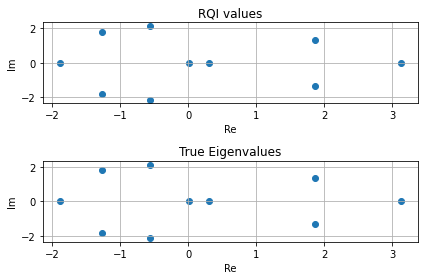

In [106]:
# Take apart the complex numbers into Re-Im components
Re_exact = [v.real for v in eigenvalues_found]
Im_exact = [v.imag for v in eigenvalues_found]
fig,ax = plt.subplots(2)
ax[0].scatter(Re_exact, Im_exact)
ax[0].grid(True)
ax[0].set_xlabel('Re')
ax[0].set_ylabel('Im')
ax[0].set_title('RQI values')

Re_exact = [v.real for v in true_eigenvalues_D]
Im_exact = [v.imag for v in true_eigenvalues_D]
ax[1].scatter(Re_exact, Im_exact)
ax[1].grid(True)
ax[1].set_xlabel('Re')
ax[1].set_ylabel('Im')
ax[1].set_title('True Eigenvalues')
plt.tight_layout()
plt.savefig('Figures/f6.eps')
plt.show()